In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp './kaggle.json' '/root/.kaggle/'

### Lấy data từ kaggle

In [ ]:
!kaggle datasets download --force -d 'tongpython/cat-and-dog'
!rm '/root/.kaggle/kaggle.json'

 95% 207M/218M [00:03<00:00, 50.5MB/s]
100% 218M/218M [00:04<00:00, 56.5MB/s]


# Import các thư viện cần thiết

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as implt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.neighbors import KNeighborsClassifier
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!unzip 'cat-and-dog.zip' -d 'my_data'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: my_data/training_set/training_set/cats/cat.3705.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3706.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3707.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3708.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3709.jpg  
  inflating: my_data/training_set/training_set/cats/cat.371.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3710.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3711.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3712.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3713.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3714.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3715.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3716.jpg  
  inflating: my_data/training_set/training_set/cats/cat.3717.jpg  
  infl

In [ ]:
train_path = 'my_data/training_set/training_set'
# valid_path = 'data/dogs-vs-cats/valid'
test_path = 'my_data/test_set/test_set'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10, shuffle=False)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

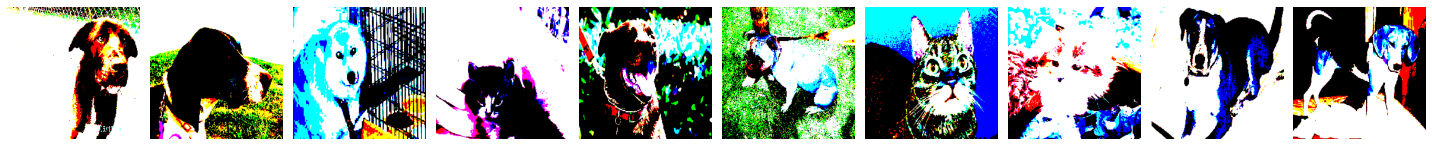

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
plotImages(imgs)
print(labels) 

## Xây dựng model

<img src="https://drive.google.com/uc?export=view&id=1pDJkc1slMWCewI-NU442KhjS8Sb9eLpe">

### **VGG16 And ImageNet**

Đây là mô hình được đào tạo trước(pre-trained model) được em sử dụng để lớp, đây là mô hình đã giành chiến thắng trong cuộc thi ImageNet năm 2014.

Trong cuộc thi ImageNet, nhiều đội cạnh tranh để xây dựng mô hình phân loại hình ảnh tốt nhất từ thư viện ImageNet. Thư viện ImageNet chứa hàng nghìn hình ảnh thuộc 1000 danh mục khác nhau.

Em sẽ sử dụng mô hình VGG16 này và sau đó tinh chỉnh nó. Mô hình VGG16 được chỉnh sẽ không phân loại hình ảnh thành một trong 1000 danh mục mà nó được đào tạo, mà thay vào đó nó sẽ chỉ hoạt động để phân loại hình ảnh là mèo hoặc chó.


In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Lớp Dense cuối cùng của VGG16 có 1000 đầu ra. Các kết quả đầu ra này tương ứng với 1000 danh mục trong thư viện ImageNet. Vì chỉ phân loại mèo và chó, nên sẽ sửa đổi mô hình này để mô hình chỉ phân loại chó và mèo.

In [ ]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

Thực hiện quá trình chuyển đổi Functional model sang Sequential model bằng cách tạo một model mới kiểu Sequential. Sau đó, lặp lại từng lớp trong vgg16_model, ngoại trừ lớp cuối cùng và thêm từng lớp vào Sequential model mới.

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

Sao chép toàn bộ vgg16_model (không bao gồm lớp đầu ra) sang một Sequential model mới vừa được đặt tên.

Tiếp theo, lặp lại từng lớp trong Sequential model mới và thiết lập thành non-trainable. Việc này nhằm đóng băng weights và các thông số có thể huấn luyện khác trong mỗi lớp để các thông số nay không được huấn luyện hoặc cập nhật.

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Train



*   Optimizer: Adam

*   Learning rate = 0.0001 
*   Hàm loss: categorical_crossentropy

*   Epoch = 20








In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x = train_batches, 
          steps_per_epoch = len(train_batches),
          epochs = 20,
          verbose = 2
         )

Epoch 1/20
801/801 - 43s - loss: 0.1045 - accuracy: 0.9609
Epoch 2/20
801/801 - 45s - loss: 0.0457 - accuracy: 0.9825
Epoch 3/20
801/801 - 46s - loss: 0.0344 - accuracy: 0.9873
Epoch 4/20
801/801 - 45s - loss: 0.0257 - accuracy: 0.9906
Epoch 5/20
801/801 - 45s - loss: 0.0208 - accuracy: 0.9925
Epoch 6/20
801/801 - 46s - loss: 0.0172 - accuracy: 0.9950
Epoch 7/20
801/801 - 45s - loss: 0.0131 - accuracy: 0.9963
Epoch 8/20
801/801 - 45s - loss: 0.0109 - accuracy: 0.9973
Epoch 9/20
801/801 - 45s - loss: 0.0084 - accuracy: 0.9985
Epoch 10/20
801/801 - 45s - loss: 0.0065 - accuracy: 0.9990
Epoch 11/20
801/801 - 45s - loss: 0.0053 - accuracy: 0.9994
Epoch 12/20
801/801 - 45s - loss: 0.0041 - accuracy: 1.0000
Epoch 13/20
801/801 - 45s - loss: 0.0034 - accuracy: 0.9999
Epoch 14/20
801/801 - 46s - loss: 0.0027 - accuracy: 1.0000
Epoch 15/20
801/801 - 45s - loss: 0.0023 - accuracy: 1.0000
Epoch 16/20
801/801 - 45s - loss: 0.0018 - accuracy: 1.0000
Epoch 17/20
801/801 - 46s - loss: 0.0015 - accura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

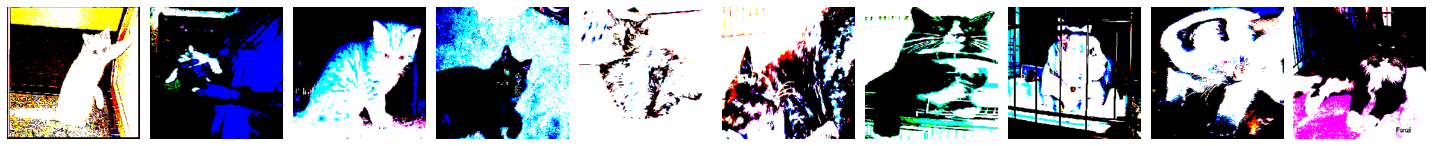

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

## Vẽ confusion matrix

In [ ]:
predictions = model.predict(x = test_batches, steps = len(test_batches), verbose = 0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[995  16]
 [ 15 997]]


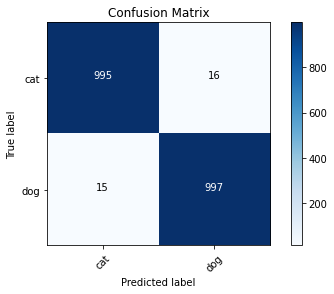

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
target_names = ["cm_plot_labels".format(i) for i in range(2)]
print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1), target_names=target_names))

                precision    recall  f1-score   support

cm_plot_labels       0.99      0.98      0.98      1011
cm_plot_labels       0.98      0.99      0.98      1012

      accuracy                           0.98      2023
     macro avg       0.98      0.98      0.98      2023
  weighted avg       0.98      0.98      0.98      2023



Model ra kết quả rất cao lên đến 98%

# Logistic Regression 

In [ ]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as implt
import seaborn as sns

from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dữ liệu


In [ ]:
# Load at the data
data_test ='my_data/test_set/test_set/'
data_train ='my_data/training_set/training_set'

train_dogs = sorted(os.listdir(data_train +'/dogs'))
train_cats =  sorted(os.listdir(data_train +'/cats'))

test_dogs = sorted(os.listdir(data_test +'/dogs'))
test_cats =  sorted(os.listdir(data_test +'/cats'))

hiện thị 1 vài ảnh chỉ định từ dữ liệu

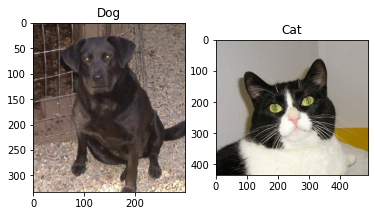

In [ ]:
img_1 = implt.imread(data_train +'/dogs/dog.3851.jpg')
img_2 = implt.imread(data_train +'/cats/cat.3041.jpg')

plt.subplot(1, 2, 1)
plt.title('Dog')
plt.imshow(img_1)       
plt.subplot(1, 2, 2)
plt.title('Cat')
plt.imshow(img_2) 

# Xử lý dữ liệu
Bộ dữ liệu chứa hình ảnh màu RGB, ta sẽ chuyển đổi những hình ảnh này sang thang độ xám. Theo cách này, ta sẽ có thể xử lý với một chiều.

Thu nhỏ và tô màu cho hình ảnh bộ train

In [ ]:
img_size = 64
dogs_images = []
cats_images = [] 
label = []

for i in train_dogs:
    if '.jpg' in i:
        if os.path.isfile(data_train +'/dogs/'+ i):
            images = Image.open(data_train +'/dogs/'+ i).convert('L') #converting grayscale         
            images = images.resize((img_size,img_size), Image.ANTIALIAS) #resizing to 64,64
            images = np.asarray(images)/255.0 #normalizing images
            dogs_images.append(images)  
            label.append(1) #label 1 for dogs
                    
for i in train_cats:
    if '.jpg' in i:
        if os.path.isfile(data_train+'/cats/'+ i):
            images = Image.open(data_train+'/cats/'+ i).convert('L')
            images = images.resize((img_size,img_size), Image.ANTIALIAS)
            images = np.asarray(images)/255.0 #normalizing images
            cats_images.append(images)  
            label.append(0) #label 0 for cats          
           
x_train = np.concatenate((dogs_images,cats_images),axis=0) # training dataset
x_train_label = np.asarray(label)# label array containing 0 and 1
x_train_label = x_train_label.reshape(x_train_label.shape[0],1)

print("dogs_images:",np.shape(dogs_images) , "cats_images:",np.shape(cats_images))
print("train_dataset:",np.shape(x_train), "train_values:",np.shape(x_train_label))


dogs_images: (4005, 64, 64) cats_images: (4000, 64, 64)
train_dataset: (8005, 64, 64) train_values: (8005, 1)


Thu nhỏ và tô màu các hình ảnh bộ test

In [ ]:
img_size = 64
dogs_images = []
cats_images = [] 
label = []

for i in test_dogs:
    if '.jpg' in i:
        if os.path.isfile(data_test +'/dogs/'+ i):
            images = Image.open(data_test +'/dogs/'+ i).convert('L') #converting grayscale            
            images = images.resize((img_size,img_size), Image.ANTIALIAS) #resizing to 64,64
            images = np.asarray(images)/255.0 #normalizing images
            dogs_images.append(images)  
            label.append(1) #label 1 for dogs
 
for i in test_cats:
    if '.jpg' in i:
        if os.path.isfile(data_test +'/cats/'+ i):
            images = Image.open(data_test +'/cats/'+ i).convert('L')
            images = images.resize((img_size,img_size), Image.ANTIALIAS)
            images = np.asarray(images)/255.0 #normalizing images
            cats_images.append(images)  
            label.append(0) #label 0 for cats       
            
x_test = np.concatenate((dogs_images,cats_images),axis=0) # test dataset
x_test_label = np.asarray(label) # corresponding labels
x_test_label = x_test_label.reshape(x_test_label.shape[0],1)

print("dogs_images:",np.shape(dogs_images), "cats_images:",np.shape(cats_images))
print("test_dataset:",np.shape(x_test), "test_values:",np.shape(x_test_label))

dogs_images: (1012, 64, 64) cats_images: (1011, 64, 64)
test_dataset: (2023, 64, 64) test_values: (2023, 1)


Kết nối mảng, nhãn của train, test 

In [ ]:
x = np.concatenate((x_train,x_test),axis=0) #train_data
y = np.concatenate((x_train_label,x_test_label),axis=0) #test data
x = x.reshape(x.shape[0],x.shape[1]*x.shape[2]) #flatten 3D image array to 2D
print("images:",x.shape, "labels:", y.shape)

images: (10028, 4096) labels: (10028, 1)


Chia dữ liệu thành dữ liệu đào tạo và kiểm tra. 20% dữ liệu sẽ là dữ liệu thử nghiệm.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = X_train.T
x_test = X_test.T
y_train = Y_train.T
y_test = Y_test.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (4096, 8022)
x test:  (4096, 2006)
y train:  (1, 8022)
y test:  (1, 2006)


# Logistic Regression không có sklearn

##Tóm tắt Logistic Regression
initialize_weights_and_bias: có giá trị ban đầu là weights và bias.

sigmoid: chức năng kích hoạt giới hạn đầu ra trong phạm vi từ 0 đến 1.

forward_backward propogation: được sử dụng để tính hàm chi phí (lỗi) và giảm độ dốc (để tìm hiểu trọng số và giá trị sai lệch phù hợp nhằm giảm thiểu lỗi).

update: cập nhật các tham số học tập 'w' và 'b' để tìm giá trị tốt nhất của chúng để đào tạo tốt hơn.

predict: sử dụng x_test làm đầu vào cho việc chuyển tiếp.




In [ ]:
def initialize_weights_and_bias(dimension):
    w=np.full((dimension,1),0.01)   
    b=0.0
    return w,b
def sigmoid(z):
    y_head=1/(1+np.exp(-z))
    return y_head
def forward_backward_propagation(w,b,x_train,y_train):
    #forward propagation
    z=np.dot(w.T,x_train)+b
    y_head=sigmoid(z)
    loss= -y_train*np.log(y_head)- (1-y_train)*np.log(1-y_head)
    cost=(np.sum(loss))/x_train.shape[1]   #x_train.shape[1] is for scaling
    
    #backward propagation
    #x_train.shape[1] is for scaling
    derivative_weight=(np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1] 
    derivative_bias=np.sum(y_head-y_train)/x_train.shape[1]
    gradients={'derivative_weight':derivative_weight,'derivative_bias':derivative_bias}
    
    return cost,gradients
def update(w,b,x_train,y_train,learnig_rate,number_of_iteration):
    cost_list=[]
    cost_list2=[]
    index=[]
    
    #updating(learning) parametres is number_of_iteration times
    for i in range(number_of_iteration):
        #make fordward and backward propagation and find cost and gradients
        cost,gradients=forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        #update
        w=w-learnig_rate*gradients['derivative_weight']
        b=b-learnig_rate*gradients['derivative_bias']
        
        if i%50 == 0:
            cost_list2.append(cost)
            index.append(i)
            print('cost after iteration %i: %f:' %(i,cost))
    
    #we update(learn) parametres weights and bias
    parameters={'weight':w,'bias':b}
    plt.figure(figsize=(4,4))
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel('Number of iteration')
    plt.ylabel('Cost')
    plt.show()
    
    return parameters,gradients,cost_list
def predict(w,b,x_test):
    z=sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction=np.zeros((1,x_test.shape[1]))
    #We're making an estimate based on our condition.
    for i in range(z.shape[1]):
        if z[0,i]<=0.5:
            Y_prediction[0,i]=0
        else:
            Y_prediction[0,i]=1
    return Y_prediction

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


cost after iteration 0: nan:
cost after iteration 50: 0.685270:
cost after iteration 100: 0.682787:
cost after iteration 150: 0.680978:
cost after iteration 200: 0.679562:
cost after iteration 250: 0.678413:
cost after iteration 300: 0.677456:
cost after iteration 350: 0.676641:
cost after iteration 400: 0.675935:
cost after iteration 450: 0.675314:


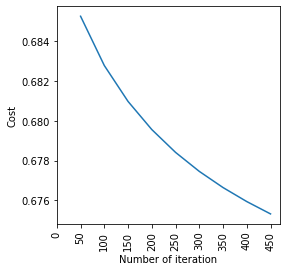

train accuracy: % 59.15
test accuracy: % 55.78


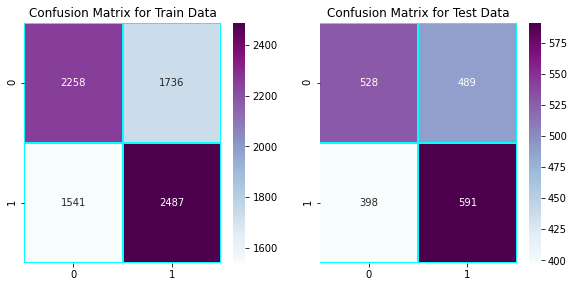

In [ ]:
def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):
    # initialize
    dimension =  x_train.shape[0]  # 4096
    w,b = initialize_weights_and_bias(dimension)
    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)

    train_acc_lr = round((100 - np.mean(np.abs(y_prediction_train - y_train)) * 100),2)
    test_acc_lr = round((100 - np.mean(np.abs(y_prediction_test - y_test)) * 100),2)

    from sklearn.metrics import confusion_matrix
    cm_test = confusion_matrix(y_test.T, y_prediction_test.T)
    cm_train = confusion_matrix(y_train.T, y_prediction_train.T)
    
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(3, 3, 1) 
    ax1.set_title('Confusion Matrix for Train Data')

    ax2 = fig.add_subplot(3, 3, 2) # row, column, position
    ax2.set_title('Confusion Matrix for Test Data')
    
    sns.heatmap(data=cm_train,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax1, cmap='BuPu')
    sns.heatmap(data=cm_test,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax2, cmap='BuPu')  
    
    
    # Print train/test Errors
    print("train accuracy: %", train_acc_lr)
    print("test accuracy: %", test_acc_lr)
    return train_acc_lr, test_acc_lr
    
train_acc_lr, test_acc_lr = logistic_regression(x_train, y_train, x_test, y_test, learning_rate = 0.003, num_iterations = 500)

kết quả cho ta thấy accuracy của train là 59.15% và test là 55.78%

kết quả khá là thấp

Ta có thể điều chỉnh `learning_rate` và `num_iteration` để kiểm tra kết quả bị ảnh hưởng như thế nào.

#Logistic Regression với sklearn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


train accuracy: 0.7364746945898778
test accuracy: 0.5314057826520439


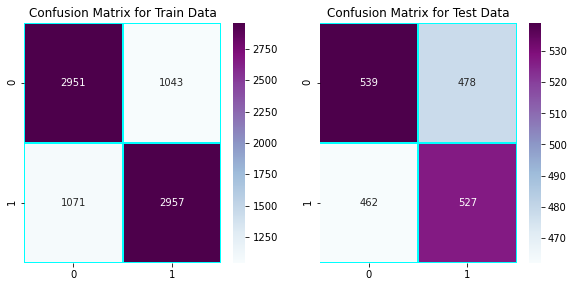

In [ ]:
#Now we use sklearn libray 
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 0)
lr.fit(x_train.T,y_train.T)

y_pred_test=lr.predict(x_test.T)
y_pred_train=lr.predict(x_train.T)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test.T, y_pred_test)
cm_train = confusion_matrix(y_train.T, y_pred_train)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax1.set_title('Confusion Matrix for Train Data')

ax2 = fig.add_subplot(3, 3, 2) # row, column, position
ax2.set_title('Confusion Matrix for Test Data')

sns.heatmap(data=cm_train,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax1, cmap='BuPu')
sns.heatmap(data=cm_test,annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax2, cmap='BuPu')  

print('train accuracy: {}'.format(lr.score(x_train.T,y_train.T)))
print('test accuracy: {}'.format(lr.score(x_test.T,y_test.T)))

kết quả khi sử dụng sklearn thì acc ở train lên đến 73.65% nhưng ở test vẫn khá thấp là 53.14% thấp hơn cả khi không sử dụng sklearn

# KNN

In [ ]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y) 

print(neigh.predict([[1.1]]))

print(neigh.predict_proba([[0.9]]))

[0]
[[0.66666667 0.33333333]]


(280, 300, 3)


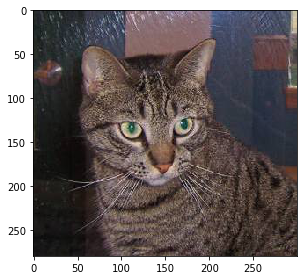

In [ ]:
from skimage import io
cat1 = io.imread('my_data/training_set/training_set/cats/cat.1.jpg')
io.imshow(cat1)
print(cat1.shape)

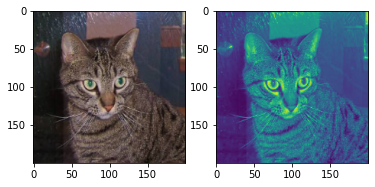

In [ ]:
from skimage.transform import resize
cat1_ = resize(cat1, (200,200,3))
from skimage.color import rgb2gray
cat1_gs = rgb2gray(cat1_)

import matplotlib.pyplot as plt
fig=plt.figure()
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(cat1_)
fig.add_subplot(rows, columns, 2)
plt.imshow(cat1_gs)
plt.show()

Nhận 200 hình ảnh đầu tiên của chó và mèo để huấn luyện

In [ ]:
x = []
y = []
for i in range(1,201):
    cat = rgb2gray(resize(io.imread('my_data/training_set/training_set/cats/cat.{}.jpg'.format(i)), (200,200)))
    x.append(cat)
    y.append(0)

for i in range(1,201):
    dog = rgb2gray(resize(io.imread('my_data/training_set/training_set/dogs/dog.{}.jpg'.format(i)), (200,200)))
    x.append(dog)
    y.append(1)

x, y = np.asarray(x), np.asarray(y) 
print('x shape: ', x.shape, 'y shape: ', y.shape)

x shape:  (400, 200, 200) y shape:  (400,)


In [ ]:
class NearestNeighbor(object):
    def __init__(self):
        pass

    def fit(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # phân loại hàng xóm gần nhất chỉ cần nhớ tất cả dữ liệu đào tạo
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k):
        # tìm hình ảnh đào tạo gần nhất với hình ảnh thử nghiệm thứ i
        # sử dụng khoảng cách L1 (tổng chênh lệch giá trị tuyệt đối)
        distances = [np.sum(np.abs(self.Xtr[i] - X)) for i in range(0, len(self.Xtr))]
        #print(distances)
        min_indexs = np.argsort(distances)[:k]
        #print(min_indexs)
        y_ = self.ytr[min_indexs]
        #print(y_)
        counts = np.bincount(y_)
        #print(np.argmax(counts))
        return np.argmax(counts)

In [ ]:
knn = NearestNeighbor()
knn.fit(x,y)
results_100 = []
for k in (1,2,3,5,10):
    print('k = ',k)
    for i in range(1,1001):
        results_100.append(knn.predict(rgb2gray(resize(io.imread('my_data/test_set/test_set/dogs/dog.{}.jpg'.format(4000+i)), (200,200))),5))
    unique, counts = np.unique(results_100, return_counts=True)
    print(dict(zip(unique, counts)))

k =  1
{0: 517, 1: 483}
k =  2
{0: 1034, 1: 966}
k =  3
{0: 1551, 1: 1449}
k =  5
{0: 2068, 1: 1932}
k =  10
{0: 2585, 1: 2415}


In [ ]:
knn = NearestNeighbor()
knn.fit(x,y)
results_100 = []
for k in (1,2,3,5,10):
    print('k = ',k)
    for i in range(1,1001):
        results_100.append(knn.predict(rgb2gray(resize(io.imread('my_data/test_set/test_set/cats/cat.{}.jpg'.format(4000+i)), (200,200))),5))
    unique, counts = np.unique(results_100, return_counts=True)
    print(dict(zip(unique, counts)))

k =  1
{0: 600, 1: 400}
k =  2
{0: 1200, 1: 800}
k =  3
{0: 1800, 1: 1200}
k =  5
{0: 2400, 1: 1600}
k =  10
{0: 3000, 1: 2000}
